In [1]:
from Models.GlassBox.ebm.ebm_class import EBM_class
import matplotlib.pyplot as  plt
import seaborn as sns
import pandas as pd

import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")
%reload_ext autoreload
%autoreload 2

In [2]:
EBM_parameter = dict(
    learning_rate= [0.005, 0.01, 0.02, 0.03],
    min_samples_leaf=[2, 3, 4, 5],
    max_leaves=[2, 3, 4],
    max_bins=[5, 8],
    outer_bags=[8, 10],
)
gridsearch_parameters = dict(
    path="./../../../outputs/scores/",
    name="0",
    nDCG_at=15
)

# Grid-search

In [3]:
gs = EBM_class(**gridsearch_parameters)

In [4]:
best_ = gs.grid_search(hyperparameters=EBM_parameter)
gs.save_model(best_[0], name="EBMReg")

Finding the best model: 100%|██████████| 192/192 [10:10<00:00,  3.18s/it, nDCG_15_at=0.983]


# Metric evaluation

In [5]:
best_model = gs.load_model(name="./saved_models/EBMReg")

In [6]:
best_model   

ExplainableBoostingRegressor(feature_names=['fitness_edu_basic',
                                            'fitness_edu_bonus', 'fitness_city',
                                            'fitness_age', 'fitness_exp_basic',
                                            'fitness_exp_bonus',
                                            'fitness_lang_basic',
                                            'fitness_lang_bonus',
                                            'fitness_comp_basic',
                                            'fitness_comp_bonus',
                                            'fitness_know_basic',
                                            'fitness_knowl_bonus',
                                            'fit_expertize',
                                            'fit_edu_judgment'],
                             interactions=0, learning_rate=0.005, max_bins=8,
                             max_rounds=8000, n_jobs=-1)

In [7]:
# nDCG on test-set
nDCG_train = gs.eval_model(model=best_model, df=gs.train, nDCG_at=[1,10,15])
nDCG_valid = gs.eval_model(model=best_model, df=gs.valid, nDCG_at=[1,10,15])
nDCG_test = gs.eval_model(model=best_model, df=gs.test, nDCG_at=[1,10,15])

display(pd.DataFrame([nDCG_train,nDCG_valid,nDCG_test],index=["Training","Validation","Test"]))

,nDCG@1,nDCG@10,nDCG@15
Training,0.9352,0.9579,0.9660
Validation,0.9424,0.9735,0.9829
Test,0.9398,0.9652,0.9753


In [8]:
from interpret import show
# show(best_model.explain_global())

# Explanation

In [9]:
best_model = gs.load_model(name="./saved_models/EBMReg")

In [10]:
best_model

ExplainableBoostingRegressor(feature_names=['fitness_edu_basic',
                                            'fitness_edu_bonus', 'fitness_city',
                                            'fitness_age', 'fitness_exp_basic',
                                            'fitness_exp_bonus',
                                            'fitness_lang_basic',
                                            'fitness_lang_bonus',
                                            'fitness_comp_basic',
                                            'fitness_comp_bonus',
                                            'fitness_know_basic',
                                            'fitness_knowl_bonus',
                                            'fit_expertize',
                                            'fit_edu_judgment'],
                             interactions=0, learning_rate=0.005, max_bins=8,
                             max_rounds=8000, n_jobs=-1)

In [11]:
gs.build_piecewise_functions(best_model)

In [12]:
list_ = gs.show_piecewise_functions(best_model)

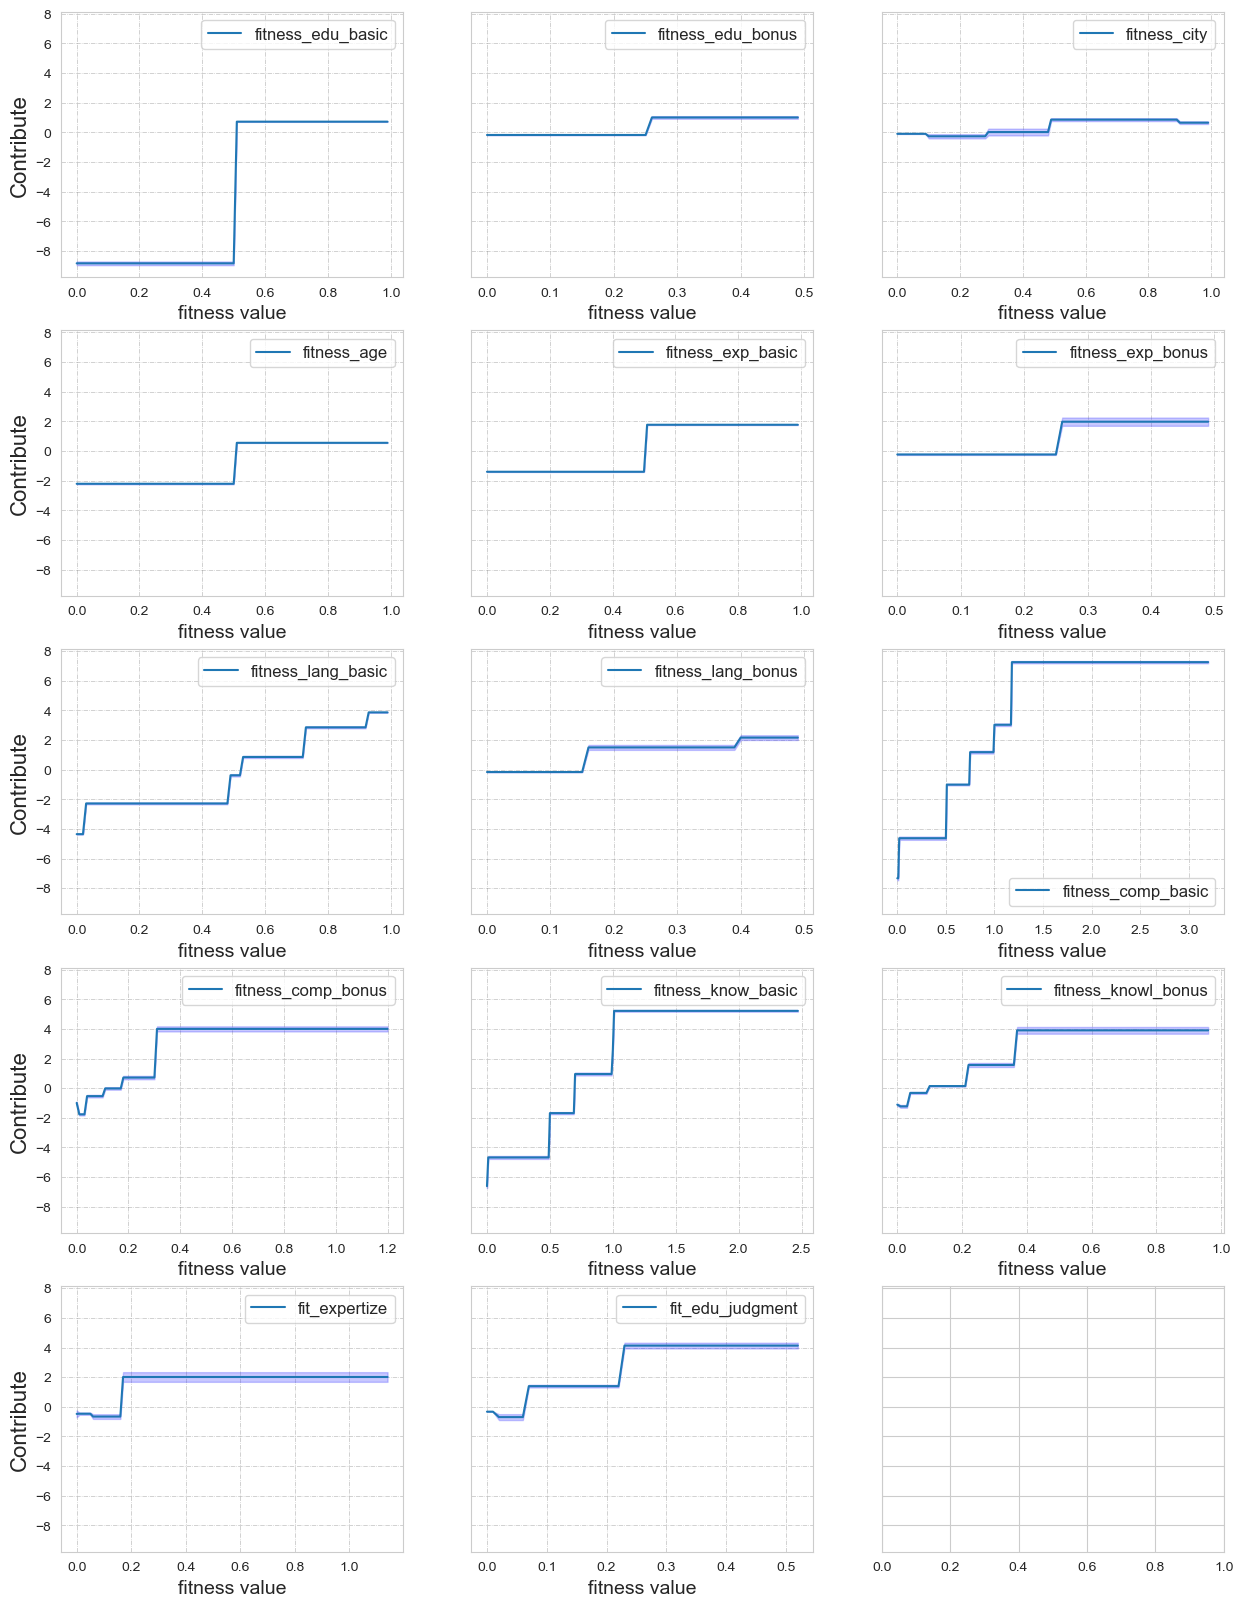

In [30]:
f, axs = plt.subplots(ncols=3,nrows=5,figsize=(15,20),sharey=True)
for i, feature in enumerate(best_model.feature_names):

    sns.lineplot(x="x",y="y",data=list_[i], label=feature, ax=axs[int(i/3)][i%3])
    axs[int(i/3)][i%3].fill_between(list_[i]['x'], list_[i]['lower'], list_[i]['upper'], color='#4B4BFF', alpha=0.3)
    axs[int(i/3)][i%3].grid(color='grey', linestyle='-.', linewidth=0.5, alpha=0.5)
    axs[int(i/3)][i%3].set_xlabel("fitness value", fontsize=14)
    axs[int(i/3)][i%3].set_ylabel("Contribute", fontsize=16)
    axs[int(i/3)][i%3].legend(fontsize=12)
plt.show()